# Statistical Analysis and GA4GH API testing with two genomic diversity datasets:


1) 1000 Genomes Project 
    - 2504 Individual Genomes
    - 26 subpopulations 
2) Simons Foundation Genome Diversity Project
    - 279 Individual Genomes 
    - 127 subpopulations 

# Import GA4GH Client Module

In [1]:
from __future__ import print_function
import ga4gh.client.client as client

# Make connection to the 1000 Genomes Project Server 

In [2]:
oneK_genomes_client = client.HttpClient("http://1kgenomes.ga4gh.org")
oneK_genomes_datasets = list( oneK_genomes_client.search_datasets() )
# get 1000 gneomes dataset 
oneK_genomes_dataset = oneK_genomes_client.get_dataset(oneK_genomes_datasets[0].id)
release = None
functional = None
# obtain the 1000 genomes variant set
for variant_set in oneK_genomes_client.search_variant_sets(dataset_id=oneK_genomes_dataset.id):
    if variant_set.name == "phase3-release":
        release = variant_set
    else:
        functional = variant_set

# Make connection to the Simons Foundation Server

In [3]:
simons_client = client.HttpClient("http://10.50.100.241/")
simons_datasets = list(simons_client.search_datasets())
# get SGDP dataset 
simons_dataset = simons_client.get_dataset(simons_datasets[0].id)

# chromosome length dictionary

this is used for random sampling regions to look for genes on each chromosome 

In [4]:
chrom_len_dict = {
    "1":249250621,
    "2":243199373,
    "3":198022430,
    "4":191154276,
    "5":180915260,
    "6":171115067,
    "7":159138663,
    "X":155270560,
    "8":146364022,
    "9":141213431,
    "10":135534747,
    "11":135006516,
    "12":133851895,
    "13":115169878,
    "14":107349540,
    "15":102531392,
    "16":90354753,
    "17":81195210,
    "18":78077248,
    "20":63025520,
    "Y" :59373566,
    "19":59128983,
    "22":51304566,
    "21":48129895,
}

# get the random regions 

for getting random regions on each chromosome 

In [5]:
import random 
def get_random_regions():
    """
    randomly samples a position in each chromosome
    :return: a dictionary of chromosome number to random position
    """

    chromosomes = chrom_len_dict.keys()

    random_regions_dict = {}
    for i in chromosomes:

        random_region = random.randrange(0,chrom_len_dict[i])

        random_regions_dict[i] = random_region

    return random_regions_dict

# bootstrapping

bootstrapping is a statistical inference method that relies on random sampling the sample size to gain insight into the population size as a whole

In [6]:
import json 
import collections
def boot_strap(filename):
    data_dict = {}   
    with open(filename) as data_file:
        data_dict = json.load(data_file)
    
    csids = data_dict.keys()
    population = data_dict.values()[0]
    random_data = {}
    for i in range(len(csids)):
        random_data[random.sample(csids,1)[0]] = population 
        
    return random_data

# get the feature set

This is used to find the names of genes and the regions that they are found in. Because gene regions are globally recognized we can use the 1000 genomes client to obtain them. 

In [7]:
for feature_set in oneK_genomes_client.search_feature_sets(dataset_id=oneK_genomes_dataset.id):
    if feature_set.name == "gencode_v24lift37":
        gencode = feature_set

feature_set = oneK_genomes_client.get_feature_set(feature_set_id=gencode.id)


# obtains genes and their start and end positions on their respective chromosomes 

In [8]:
# for random sampling genes on each chromosome 
def get_gene_regions():

    """
    randomly samples 10 genes from each chromosome and finds their start and end positions
    :return: dictionary of chromosomes with 10 genes for each chromosome and their positions
    """

    rrd = get_random_regions()

    regions = {}
    for chrom,region in rrd.iteritems():

        genes = {}
        stop = chrom_len_dict[chrom]
        for features in oneK_genomes_client.search_features(feature_set_id=feature_set.id,feature_types=['gene'],start=region, end=stop):

            if len(genes) == 10: break 

            genes[features.gene_symbol] = (int(features.start), int(features.end))

        regions[chrom] = genes

    return regions


# obtains the allele frequencies for the random sampled genes on a given chromsome 

In [9]:
import json
from collections import defaultdict
# for getting allele frequencies from random sampled genes in their respective regions 
def get_af_for_genes(client,genes,chrom,filename, variant_set, bootstrap):
    """
    finds allele frequencies for random sampled genes on a given chromosome and variant set
    there is a boolean option for whether the data should be bootstrapped 
    """
    if bootstrap == True:
        pop_dict = boot_strap(filename)
    else:
        pop_dict = {}
        with open(filename) as data_file:
            pop_dict = json.load(data_file)

    cs_ids = pop_dict.keys()
    n = float(len(pop_dict))
    chrom_dict = {}
    genes = genes[chrom]
    gene_dict = {} 
    for gene,positions in genes.iteritems():
        i = 0
        individual_dict = {}
        allele_dict = defaultdict(list)
        alleles = []
        for v in client.search_variants(variant_set_id=variant_set.id,call_set_ids=cs_ids,
            start= positions[0],end=positions[1], reference_name=chrom):
            if i > 100: break
            count = 0.0
            for co in v.calls:
                 
                if len(co.genotype) > 1:
                    A1 = co.genotype[0]
                    A2 = co.genotype[1]
                else:
                    A1 = co.genotype[0]
                    A2 = 0
                if (((A1 + A2 ) > 0)):
                    count += 1

            af = count / n 
            if ( af > 0.0 and len(v.names) > 0 ):
                allele_dict[v.names[0]].append(af)
            i += 1
        gene_dict[gene] = allele_dict
     
    chrom_dict[chrom] = gene_dict

    return chrom_dict 

In [ ]:
genes = {}
genes = get_gene_regions()

mxl_info = get_af_for_genes(oneK_genomes_client,genes,"1",'./1kgenomes_csids/MXL.json', release,False)

In [16]:
def get_data_matrix(chrom_dict, chrom):

    data_matrix = []
    name_row = ['gene','variant','allele frequency']
    data_matrix.append(name_row)
    for gene, allele_dict in chrom_dict[chrom].iteritems():
        row = []
        row.append(gene)
        alleles = allele_dict.keys()
        i = 0
        for allele in alleles:
            if i >= 1:
                row.append(" ")
            row.append(allele)
            row.append( list(allele_dict[allele] )[0] )
            i += 1
            data_matrix.append(row)
            row = []

    return data_matrix

In [17]:
%%javascript
// run this javascript to supress output scrolling 
// IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Table Shows Allele Frequencies in Randomly Sampled Genes

In [18]:
import sys
import os
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Figure, Layout

data_matrix = get_data_matrix(mxl_info, str(1))
data_matrix.insert(0,['Chromosome 1 Variant Frequencies in Mexican Subpopulation in Los Angeles','',''])
table = ff.create_table(data_matrix, index=True)

# Make text size larger
for i in range(len(table.layout.annotations)):
    table.layout.annotations[i].font.size = 15

# redirect plotly message to file and then remove it
sys.stdout = open('plotly_message.txt','w')
os.remove('plotly_message.txt')

# plot and save table
py.image.save_as(table, filename='raw-allele-frequencies.png')

# Bootstrap data on data in Great Britain and Japan subpopulation Groups 100 times

Graph the Gaussian ditribution for a rare and a common variant in one of the genes analyzed in the bootstrap

In [12]:
genes = get_gene_regions()
gbr_data = []
for i in range(0,100):
    chrom_dict = get_af_for_genes(oneK_genomes_client,genes,"1",'./1kgenomes_csids/GBR.json', release,True)
    gbr_data.append(chrom_dict)

In [13]:
jpt_data = []
for i in range(0,100):
    chrom_dict = get_af_for_genes(oneK_genomes_client,genes,"1",'./1kgenomes_csids/JPT.json', release,True)
    jpt_data.append(chrom_dict)

In [35]:
def get_rare_and_common_alleles_data(data):    
    # common variant
    common_allele_data = []
    # rare variant
    rare_allele_data = []
    i = 0
    for element in data:
        for gene,allele_dict in element['1'].iteritems():     
            min_allele = 'rs77801739'
            max_allele = 'rs1926871'
            alleles = allele_dict.keys()
            if gene == 'TSEN15':
                if len((allele_dict[min_allele])) > 0.0:
                    rare_allele_data.append(list(allele_dict[min_allele])[0])
                if len(allele_dict[max_allele]) > 0.0:
                    common_allele_data.append(list(allele_dict[max_allele])[0])
    return common_allele_data, rare_allele_data

In [19]:
gbr_common_allele_data, gbr_rare_data = get_rare_and_common_alleles_data(gbr_data)
jpt_common_allele_data, jpt_rare_data = get_rare_and_common_alleles_data(jpt_data)

# Gaussian Distribution For Variants in TSEN15 gene

From the UCSC Genome Browser:

"Non-catalytic subunit of the tRNA-splicing endonuclease complex, a complex responsible for identification and cleavage of the splice sites in pre-tRNA. It cleaves pre-tRNA at the 5' and 3' splice sites to release the intron."

In [37]:
import numpy as np
import scipy.stats as stats
import pylab as pl

def graph_data(data,example,subpop):
    # common variant
    data = sorted(data)
    fit = stats.norm.pdf(data, np.mean(data), np.std(data))
    pl.plot(data,fit,'-o')
    pl.hist(data,normed=True)      
    pl.xlabel('allele frequency')
    pl.ylabel('normal density')
    if example == "Common":
        pl.title(subpop + ': '+ example + ' Variant: rs1926871')
    else: pl.title(subpop + ': '+ example + ' Variant: rs77801739')
    pl.show()                   

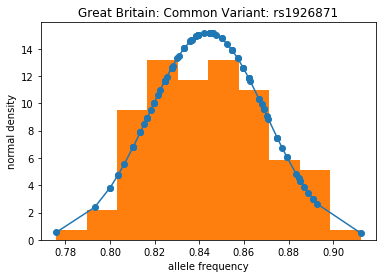

In [38]:
graph_data(gbr_common_allele_data,"Common","Great Britain")

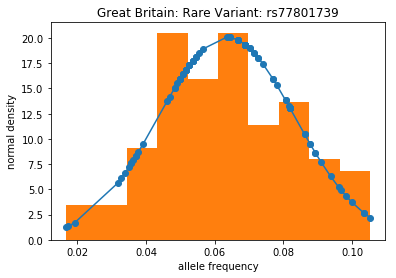

In [39]:
graph_data(gbr_rare_data,"Rare","Great Britain")

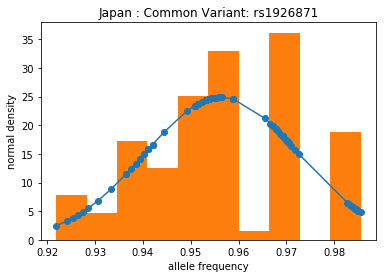

In [40]:
graph_data(jpt_common_allele_data,"Common","Japan ")

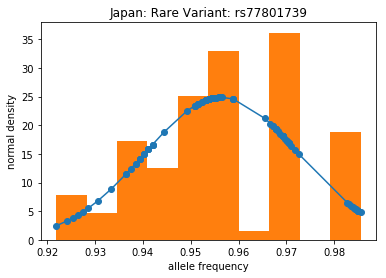

In [41]:
graph_data(jpt_common_allele_data,"Rare","Japan")

# Difference between analyzing individuals in a single variant set versus across variant sets

Individuals in the 1000 genomes dataset all belong to the same variant set so their call set ids can be compared between one another.
However in the SGDP dataset, each individual belongs to their own variant set so their call set ids cannot be compared to other
individuals of different variant sets.

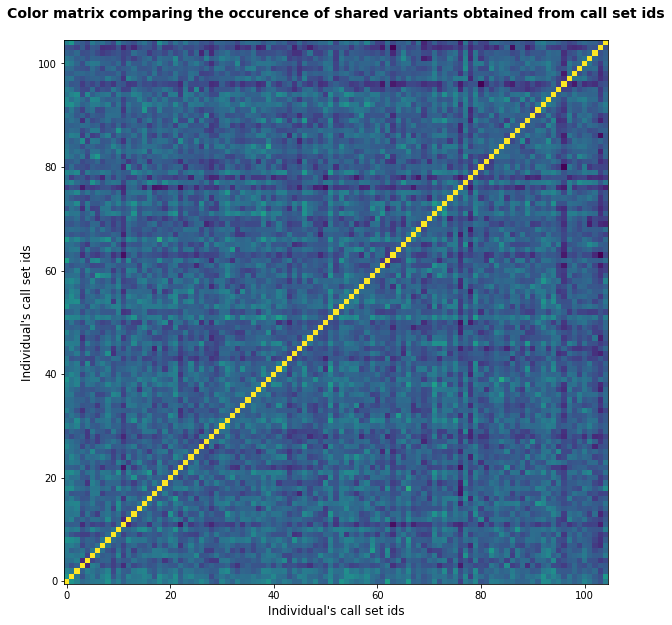

In [23]:
import json 
pop_dict = {}
with open("./1kgenomes_csids/CHS.json") as data_file:
    pop_dict = json.load(data_file)
    
callSetIds = pop_dict.keys()
pairs = pop_dict.values()


import variantMatrix
vm = variantMatrix.VariantMatrix(oneK_genomes_dataset, oneK_genomes_client, 
                                [release.id], callSetIds, len(callSetIds),"3", 1000000,3000000)
vm.visualize_matrix_color()

The 279 variant sets in the SGDP data cannot be cross compared because their callSets are not a part of each others variant sets 

In [129]:
import json
pop_dict = {}
with open ("./simons_csids/simons_csids.json") as data_file:
    pop_dict = json.load(data_file)

callSetIds = pop_dict.keys()
pairs = pop_dict.values()
variantSetIds = []
for i in pairs:
    variantSetIds.append(i[1])

import variantMatrix
vm = variantMatrix.VariantMatrix(simons_dataset,simons_client, 
                                 variantSetIds, callSetIds, 4, "2", 500000,1000000  )

ERROR:ga4gh.client.client:404 {"errorCode": 1971332027, "message": "callSet 'WyJTaW1vbnMiLCJ2cyIsIkxQNjAwNTQ0Mi1ETkFfRjAyIiwiTFA2MDA1NDQyLUROQV9GMDIiXQ' not in variantSet 'WyJTaW1vbnMiLCJ2cyIsIkxQNjAwNTQ0My1ETkFfQzA4Il0'"}


RequestNonSuccessException: Url http://10.50.100.241/variants/search had status_code 404